### Slow-wave activity (SWA) detection

1. Filter with 0.5~4 Hz bandpass filter
2. Find negative peaks
3. Find zero around negatie peaks
4. Find positive peak after the zero
5. Add threshold to find true swa

In [180]:
import misleep
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [42]:
midata = misleep.load_mat(data_path=r'\\172.16.41.188\wangxueqiang\EEG_data\TechMan\20240524_190000\20240524_190000.mat')
mianno = misleep.load_misleep_anno(r'\\172.16.41.188\wangxueqiang\EEG_data\TechMan\20240524_190000\label.txt')

#### Do filter and crop example data

In [43]:
midata.filter(chans=['EEG_2'])
midata.filter(chans=['EEG_2'], low=0.5, high=4)

In [44]:
midata.channels

['EEG_1', 'EEG_2', 'EMG_DIFF', 'EEG_2_bandpass_0.5_30', 'EEG_2_bandpass_0.5_4']

In [53]:
# crop data
example_data = midata.crop([44313, 44343]).pick_chs(['EEG_2_bandpass_0.5_30'])
delta_data = midata.crop([44313, 44343]).pick_chs(['EEG_2_bandpass_0.5_4'])

#### Find positive/negative peaks, with amplitude threshold. And also zero crossing

In [136]:
# Find positive/negative peaks with delta data
pos_peak_idx, _ = find_peaks(delta_data.signals[0], (75))
neg_peak_idx, _ = find_peaks(-1*delta_data.signals[0], (75))
zero_crossing = [idx for idx, each in enumerate(np.diff(np.signbit(delta_data.signals[0]), axis=0)) if each]
zero_crossing = np.array(zero_crossing, dtype=np.int64)

#### Find proper sequence of start_zero -> negative_peak -> zero -> positive_peak -> end_zero 

In [158]:
# find the positive peak after negative peak

negative_peaks_hold = [[], []]
positive_peaks_hold = [[], []]
zero_crossing_hold = [[], []]
for neg_idx in neg_peak_idx:
    # find the zero cross after the current negative peak
    for zero_idx in zero_crossing:
        if zero_idx > neg_idx:
            # find the positive peak after the zero cross
            for pos_idx in pos_peak_idx:
                if pos_idx > zero_idx and zero_idx not in zero_crossing_hold[0]:
                    # no zero cross between pos and zero, neg and zero
                    if True not in (delta_data.signals[0][zero_idx+1: pos_idx] <= 0) and True not in (delta_data.signals[0][neg_idx: zero_idx] >= 0):
                        negative_peaks_hold[0].append(neg_idx)
                        negative_peaks_hold[1].append(delta_data.signals[0][neg_idx])
                        
                        positive_peaks_hold[0].append(pos_idx)
                        positive_peaks_hold[1].append(delta_data.signals[0][pos_idx])

                        zero_crossing_hold[0].append(zero_idx)
                        zero_crossing_hold[1].append(delta_data.signals[0][zero_idx])
                
                    break
            break


In [172]:
# find the zero before negative peak and after positive peak
# see np.searchsorted(a, v) insert v's element into a, find the index which will make the a's order preserve
start_zero_cross_hold = zero_crossing[:-1][np.diff(np.searchsorted(negative_peaks_hold[0], zero_crossing)).astype(bool)]
start_zero_cross_hold = [start_zero_cross_hold, delta_data.signals[0][start_zero_cross_hold]]

end_zero_cross_hold = zero_crossing[np.searchsorted(zero_crossing, positive_peaks_hold[0])]
end_zero_cross_hold = [end_zero_cross_hold, delta_data.signals[0][end_zero_cross_hold]]


#### Plot

(0.0, 15000.0)

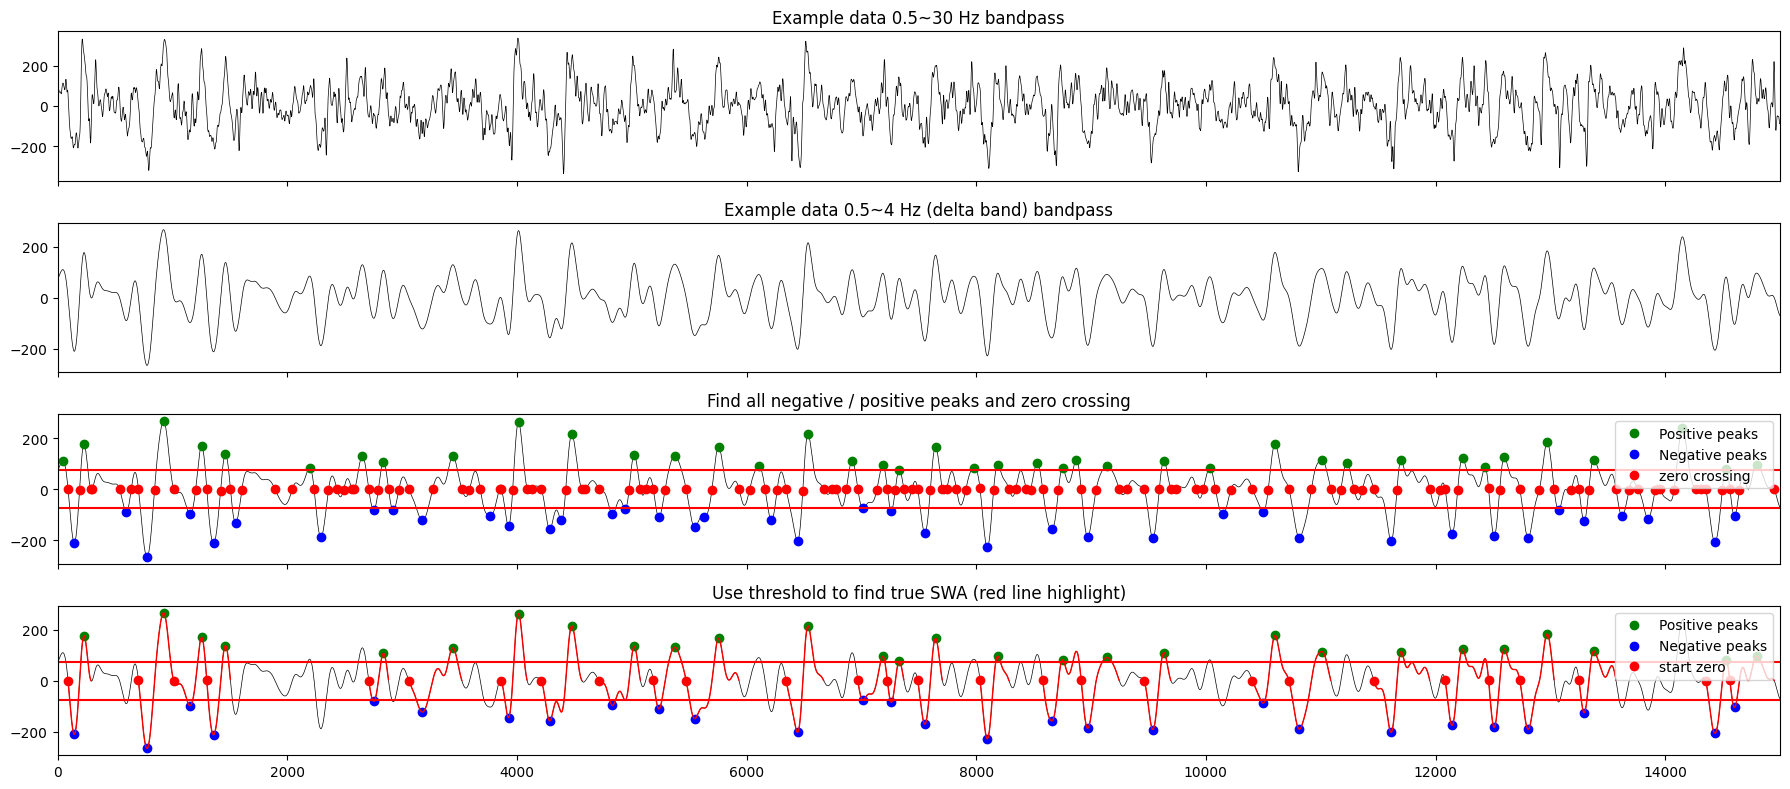

In [235]:
fig = plt.figure(figsize=(18, 8))
axs = fig.subplots(nrows=4, ncols=1, sharex=True)
fig.set_tight_layout(2)

axs[0].set_title('Example data 0.5~30 Hz bandpass')
axs[0].plot(example_data.signals[0], color='black', linewidth=0.5)

axs[1].set_title('Example data 0.5~4 Hz (delta band) bandpass')
axs[1].plot(delta_data.signals[0], color='black', linewidth=0.5)

axs[2].set_title('Find all negative / positive peaks and zero crossing')
axs[2].plot(delta_data.signals[0], color='black', linewidth=0.5)
axs[2].plot(pos_peak_idx, delta_data.signals[0][pos_peak_idx], 'go', label='Positive peaks')
axs[2].plot(neg_peak_idx, delta_data.signals[0][neg_peak_idx], 'bo', label='Negative peaks')
axs[2].plot(zero_crossing, delta_data.signals[0][zero_crossing], 'ro', label='zero crossing')
axs[2].axhline(75, color='red')
axs[2].axhline(-75, color='red')
axs[2].legend(loc='upper right')

axs[3].set_title('Use threshold to find true SWA (red line highlight)')
axs[3].plot(delta_data.signals[0], color='black', linewidth=0.5)
axs[3].plot(positive_peaks_hold[0], positive_peaks_hold[1], 'go', label='Positive peaks')
axs[3].plot(negative_peaks_hold[0], negative_peaks_hold[1], 'bo', label='Negative peaks')
axs[3].plot(start_zero_cross_hold[0], start_zero_cross_hold[1], 'ro', label='start zero')
[axs[3].plot(range(each, end_zero_cross_hold[0][idx]), delta_data.signals[0][each: end_zero_cross_hold[0][idx]], color='red', linewidth=1) 
 for idx, each in enumerate(start_zero_cross_hold[0])]
axs[3].axhline(75, color='red')
axs[3].axhline(-75, color='red')
axs[3].legend(loc='upper right')

axs[0].set_xlim(0, len(example_data.signals[0]))
axs[1].set_xlim(0, len(delta_data.signals[0]))
axs[2].set_xlim(0, len(delta_data.signals[0]))
axs[3].set_xlim(0, len(delta_data.signals[0]))


#### Find true SWA
1. amplitude is between 75 uV and 400 uV (temporary), already done when use find_peaks function
2. Frequency is between 0.5 ~ 4 Hz, optional

In [240]:
df_lst = []
sf = 500

before = int(0.4 * sf)
after = int(0.8 * sf)
total_array = []
for idx, start_zero in enumerate(start_zero_cross_hold[0]):
    start_time = start_zero/sf
    end_time = end_zero_cross_hold[0][idx]/sf
    total_duration = end_time - start_time
    frequency = 1/total_duration
    if frequency > 4 or frequency < 0.5:
        continue

    middle_cross_time = zero_crossing_hold[0][idx] / sf

    time_pos_peak = positive_peaks_hold[0][idx] / sf
    val_pos_peak = positive_peaks_hold[1][idx]
    time_neg_peak = negative_peaks_hold[0][idx] / sf
    val_neg_peak = negative_peaks_hold[1][idx]

    peak_to_peak = val_pos_peak - val_neg_peak

    slope = peak_to_peak / (time_pos_peak - time_neg_peak)

    df_lst.append([start_time, time_neg_peak, middle_cross_time, time_pos_peak, 
                   end_time, total_duration, val_neg_peak, val_pos_peak, 
                   peak_to_peak, slope, frequency])
    if time_neg_peak > 1 and delta_data.signals[0].shape[0] - negative_peaks_hold[0][idx] > after:
        total_array.append(delta_data.signals[0][int(negative_peaks_hold[0][idx]-before): int(negative_peaks_hold[0][idx]+after)])


In [241]:
pd.DataFrame(df_lst, columns=['StartTime', 'NegTime', 'MiddleTime', 'PosTime', 'EndTime', 'Duration', 'NegPeak', 'PosPeak', 'PTP', 'Slope', 'Frequency'])

,StartTime,NegTime,MiddleTime,PosTime,EndTime,Duration,NegPeak,PosPeak,PTP,Slope,Frequency
0,0.182,0.290,0.382,0.460,0.584,0.402,-210.282226,177.827265,388.109491,2282.997005,2.487562
1,1.408,1.558,1.688,1.846,2.020,0.612,-265.889333,267.689639,533.578972,1852.704764,1.633987
2,2.020,2.306,2.404,2.508,2.598,0.578,-97.675832,170.845400,268.521232,1329.313029,1.730104
3,2.598,2.716,2.838,2.924,3.010,0.412,-212.385119,138.751116,351.136235,1688.154976,2.427184
4,5.420,5.506,5.586,5.676,5.764,0.344,-80.564121,108.279574,188.843695,1110.845267,2.906977
5,6.118,6.354,6.530,6.884,7.042,0.924,-122.549428,129.868126,252.417555,476.259538,1.082251
6,7.722,7.854,7.926,8.028,8.178,0.456,-144.552665,263.941266,408.493931,2347.666273,2.192982
7,8.422,8.572,8.850,8.956,9.132,0.710,-157.611408,215.735924,373.347332,972.258677,1.408451
8,9.434,9.664,9.954,10.044,10.152,0.718,-96.769829,135.730633,232.500462,611.843322,1.392758
9,10.374,10.474,10.580,10.748,10.948,0.574,-110.467134,132.036501,242.503635,885.049763,1.742160


#### plot average

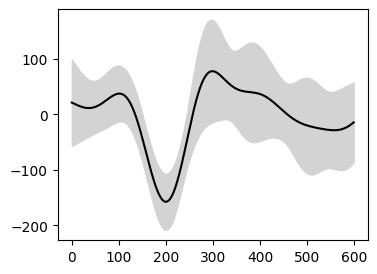

In [242]:
fig = plt.figure(figsize=(4, 3))
axs = fig.subplots(nrows=1, ncols=1)

total_array = np.array(total_array)

std_array = np.std(total_array, axis=0)
mean_array = np.mean(total_array, axis=0)

x = range(total_array.shape[1])
axs.fill_between(x, mean_array-std_array, mean_array+std_array, color='lightgray')
axs.plot(mean_array, color='black')